analysis for ELS mice and age matched controls.
GT 4/19/20222


In [ ]:
import os.path
import sys
import glob

import matplotlib.pyplot as plt
import numpy as np
# for slope calculation
from scipy.stats import linregress
from scipy.stats import ttest_ind
import seaborn as sns
# sns.set(font_scale = 1.5)
# sns.set_style("white")
import pandas as pd

%matplotlib inline

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

from google.colab import drive
drive.mount('/content/drive')

save_dir = '/content/drive/Shareddrives/TuriLab/Data/PTSD_project/ELS_PTSD_ns/!ptsd_els_analysis/output_official/'

Mounted at /content/drive


To creat the `stim_interval_freezing` i loaded the sefla trials in freezview5 and set up an export with custom intervals. the intervals can be found in `sefla_shock_sequence` sheet. i used .5s bouts. 

In [ ]:
worksheet = gc.open('stim_interval_freezing_w_ELS').sheet1

# get_all_values gives a list of rows.
data = worksheet.get_all_values()
# print(data)

# Convert to a DataFrame and render.
import pandas as pd
df = pd.DataFrame.from_records(data)
df.columns = df.iloc[0]
df.drop(df.index[0], inplace =True)
df.reset_index(inplace=True, drop=True)


# converting number strings to number
df[["Pre", "Shock01", "Shock02", "Shock03",
       "Shock04", "Shock05", "Shock06",
       "Shock07", "Shock08", "Shock09",
       "Shock10"]] = df[["Pre", "Shock01", "Shock02", "Shock03",
       "Shock04", "Shock05", "Shock06",
       "Shock07", "Shock08", "Shock09",
       "Shock10"]].apply(pd.to_numeric)

df['cohort_id'] = df['Cohort']+'_'+df['id']
# dropping two ambigous columns
df.drop(['Cohort', 'id'], axis=1, inplace=True)
# iv_df.head()

df.head()
# df.shape

,Group,ELS,Sex,genotype,Pre,Shock01,Shock02,Shock03,Shock04,Shock05,Shock06,Shock07,Shock08,Shock09,Shock10,cohort_id
0,Control,no ELS,Male,wt,0.46,3.08,7.83,2.70,2.70,0.75,5.87,2.04,3.67,4.71,3.85,ptsd2_81
1,Control,no ELS,Male,wt,2.20,7.32,5.78,6.37,8.28,13.89,12.86,8.15,7.91,12.19,13.84,ptsd2_82
2,Control,no ELS,Male,wt,0.55,2.09,2.40,4.05,1.67,2.48,2.42,2.96,1.39,4.34,1.93,ptsd2_91
3,Control,no ELS,Male,wt,0.00,1.35,6.41,1.57,1.02,1.51,1.57,0.61,2.47,0.45,2.89,ptsd2_92
4,Control,no ELS,Male,wt,0.00,2.71,0.71,3.00,7.16,6.14,1.11,3.98,4.62,12.64,8.66,ptsd3_12


In [ ]:
worksheet = gc.open('id_dob').sheet1

# get_all_values gives a list of rows.
data = worksheet.get_all_values()
# print(data)

# Convert to a DataFrame and render.
import pandas as pd
dob_df = pd.DataFrame.from_records(data)
dob_df.columns = dob_df.iloc[0]
dob_df.drop(dob_df.index[0], inplace=True)
dob_df.reset_index(inplace=True, drop=True)

dob_df['cohort_id']= dob_df['cohort']+'_'+dob_df['id']
dob_df.drop(['id', 'cohort'], axis=1, inplace=True )
dob_df['dob'] = dob_df['dob'].astype('datetime64[ns]')

dob_df.head()
print(f'dob_df shape{dob_df.shape}')

dob_df shape(147, 2)


merging freezing with DOB-s. Although this is not necessary bc we will not use this info later on. 

In [ ]:
merged_df = df.merge(dob_df,left_on='cohort_id', right_on='cohort_id')
merged_df

,Group,ELS,Sex,genotype,Pre,Shock01,Shock02,Shock03,Shock04,Shock05,Shock06,Shock07,Shock08,Shock09,Shock10,cohort_id,dob
0,Control,no ELS,Male,wt,0.46,3.08,7.83,2.70,2.70,0.75,5.87,2.04,3.67,4.71,3.85,ptsd2_81,2021-02-16
1,Control,no ELS,Male,wt,2.20,7.32,5.78,6.37,8.28,13.89,12.86,8.15,7.91,12.19,13.84,ptsd2_82,2021-02-16
2,Control,no ELS,Male,wt,0.55,2.09,2.40,4.05,1.67,2.48,2.42,2.96,1.39,4.34,1.93,ptsd2_91,2021-02-16
3,Control,no ELS,Male,wt,0.00,1.35,6.41,1.57,1.02,1.51,1.57,0.61,2.47,0.45,2.89,ptsd2_92,2021-02-16
4,Control,no ELS,Male,wt,0.00,2.71,0.71,3.00,7.16,6.14,1.11,3.98,4.62,12.64,8.66,ptsd3_12,2021-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,Control,ELS,Female,wt,0.00,0.62,31.94,1.57,4.74,7.21,4.70,4.89,12.52,7.85,3.13,els1_868-2,2021-10-18
125,Control,ELS,Female,wt,0.00,2.58,15.93,14.54,6.98,18.84,8.09,22.73,27.70,5.98,45.37,els1_868-3,2021-10-18
126,Control,no ELS,Female,wt,0.00,2.58,6.76,5.10,1.67,3.55,1.76,5.71,4.68,9.05,1.20,els1_921-2,2021-10-25
127,Control,no ELS,Female,wt,1.65,4.37,6.76,3.37,16.93,4.84,1.31,21.30,35.48,7.11,43.32,els1_921-3,2021-10-25


filtering out the mice we will work with.

In [ ]:
age_matched_controls = ['ptsd3_2', 'ptsd3_12',
       'ptsd3_1', 'ptsd3_3', 'ptsd3_11', 'ptsd5_11', 'ptsd5_61',
       'ptsd5_12', 'ptsd5_13', 'ptsd5_64', 'ptsd5_62'] 
       
       # no data for these two: 'ptsd1_sert26a-3', 'ptsd1_sert26a-2', 

els_mice = df[df['cohort_id'].str.startswith('els1')]
print(f'els mice: {els_mice.shape}')

age_matched_mice = df[df['cohort_id'].isin(age_matched_controls)]
print(f'age matched mice: {age_matched_mice.shape}')

els_age_matched = pd.concat([els_mice, age_matched_mice], axis=0)
print(f'els and age matched: {els_age_matched.shape}')

els mice: (42, 16)
age matched mice: (11, 16)
els and age matched: (53, 16)



Melting the df to the long form

In [ ]:
df = els_age_matched
melted_df = pd.melt(df, id_vars=['cohort_id', 'Group', 'Sex', 'genotype', 'ELS'],
                    value_vars=df.columns[4:-1])

# renaming one column
melted_df.rename(columns={0: "Condition", 'value': 'Freezing (%)'},
                 inplace=True)
melted_df.head(2)

#############################
#saving the data on disk as #
# as a CSV. uncomment if you# 
# need                      #
#############################


# melted_df.to_csv(os.path.join(save_dir, "els_mice_age_matched_ctrl_intervals.csv"))

,cohort_id,Group,Sex,genotype,ELS,Condition,Freezing (%)
0,els1_922-1,Control,Male,wt,ELS,Pre,11.8
1,els1_922-2,Control,Male,wt,ELS,Pre,0.0


adding time column to df 

In [ ]:
# constructing dictionary with numerical values that replace the strings
conditions = melted_df['Condition'].unique()
times = np.arange(0, 3600, 350)
cond_dict = dict(zip(conditions, times))
# adding an empty column
melted_df['time'] = pd.Series.empty

In [ ]:
melted_df.head(2)

,cohort_id,Group,Sex,genotype,ELS,Condition,Freezing (%),time
0,els1_922-1,Control,Male,wt,ELS,Pre,11.8,<property object at 0x7f966d37c3b0>
1,els1_922-2,Control,Male,wt,ELS,Pre,0.0,<property object at 0x7f966d37c3b0>


In [ ]:
def filler(row):
  """fills in the field according to the content 
  of a dictionary"""
  for key in cond_dict.keys():
    if row == key:
      val = cond_dict[key]
  return val

In [ ]:
melted_df['time'] = melted_df['Condition'].apply(filler)

In [ ]:
print(f'all mice: {len(melted_df.cohort_id.unique())}')
print(f'\n ================ \n')
print(melted_df.groupby('Group')['cohort_id'].nunique())
print(f'\n ================ \n')
print(melted_df.groupby(['Group', 'Sex'])['cohort_id'].nunique())
print(f'\n ================ \n')
print(melted_df.groupby(['Group', 'genotype'])['cohort_id'].nunique())
print(f'\n ================ \n')
print(melted_df.groupby(['Group', 'ELS'])['cohort_id'].nunique())
print(f'\n ================ \n')
print(melted_df.groupby(['Group', 'ELS', 'Sex'])['cohort_id'].nunique())

all mice: 53


Group
Control    26
SEFL       27
Name: cohort_id, dtype: int64


Group    Sex   
Control  Female    16
         Male      10
SEFL     Female    16
         Male      11
Name: cohort_id, dtype: int64


Group    genotype
Control  wt          26
SEFL     wt          27
Name: cohort_id, dtype: int64


Group    ELS   
Control  ELS       16
         no ELS    10
SEFL     ELS       14
         no ELS    13
Name: cohort_id, dtype: int64


Group    ELS     Sex   
Control  ELS     Female    11
                 Male       5
         no ELS  Female     5
                 Male       5
SEFL     ELS     Female    10
                 Male       4
         no ELS  Female     6
                 Male       7
Name: cohort_id, dtype: int64


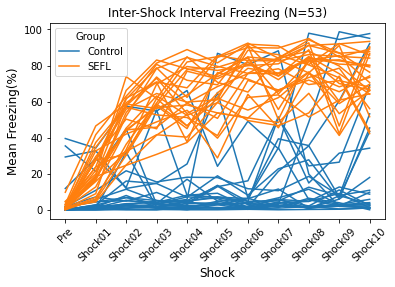

In [ ]:
# selected mice broken down to SEFL and CONTROL
plt.figure()
g = sns.lineplot(data=melted_df, x='Condition', y='Freezing (%)', hue='Group', 
                 units='cohort_id', estimator=None)
plt.setp(g.get_xticklabels(), rotation=45)
plt.xlabel('Shock', size=12)
plt.ylabel('Mean Freezing(%)', size=12)
plt.title("Inter-Shock Interval Freezing (N={})".format(len(melted_df.cohort_id.unique())))
bbox_inches="tight"

plt.gcf().subplots_adjust(bottom=0.2)

# alternate option without .gcf
plt.subplots_adjust(bottom=0.2)
# plt.savefig(os.path.join(save_dir, 'IS_freezing_ELS_control_mice_grouped_04_20.png'),
#             transparent=True, dpi=300, figsize = (8,6))

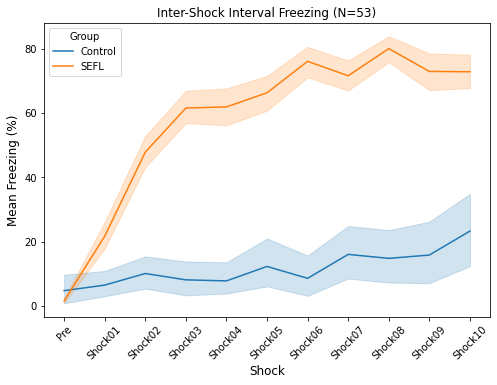

In [ ]:
# all mice broken down to SEFL-CONTROL 
plt.figure(figsize = (8,6))
g = sns.lineplot(data=melted_df, x='Condition', y='Freezing (%)',
             hue='Group')
plt.setp(g.get_xticklabels(), rotation=45)
plt.xlabel('Shock', size=12)
plt.ylabel('Mean Freezing (%)', size=12)
num_mice = melted_df.cohort_id.nunique()
plt.title("Inter-Shock Interval Freezing (N={})".format(num_mice))
g.get_legend_handles_labels({})

bbox_inches="tight"

plt.gcf().subplots_adjust(bottom=0.2)

# alternate option without .gcf
plt.subplots_adjust(bottom=0.2)

# plt.savefig(os.path.join(save_dir,
#                          'Inter-shock_SEFL_control_freezing_all_mice_04_20.png'),
#             transparent=True, dpi=300)

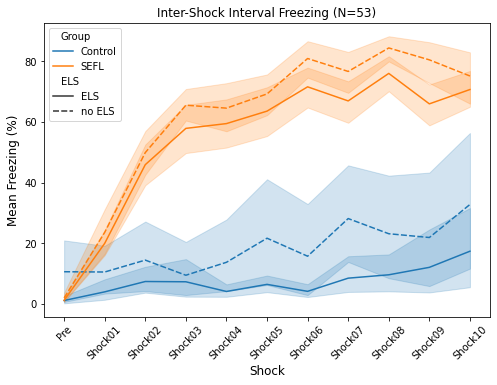

In [ ]:
# all mice broken down to SEFL-CONTROL and ELS
plt.figure(figsize = (8,6))
g = sns.lineplot(data=melted_df, x='Condition', y='Freezing (%)',
             hue='Group', style='ELS')
plt.setp(g.get_xticklabels(), rotation=45)
plt.xlabel('Shock', size=12)
plt.ylabel('Mean Freezing (%)', size=12)
plt.title("Inter-Shock Interval Freezing (N={})".format(melted_df.cohort_id.nunique()))
g.get_legend_handles_labels({})

bbox_inches="tight"

plt.gcf().subplots_adjust(bottom=0.2)

# alternate option without .gcf
plt.subplots_adjust(bottom=0.2)

# plt.savefig(os.path.join(save_dir, 'Inter-shock_sefl_control_freezing_4_20.png'),
#             transparent=True, dpi=300)

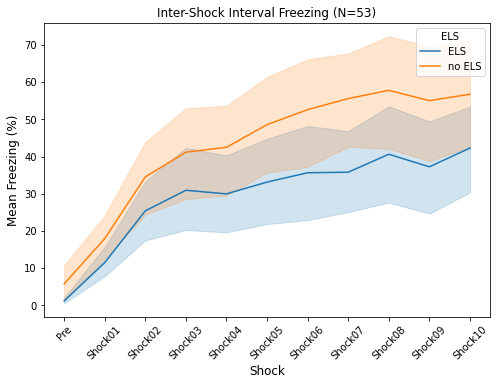

In [ ]:
# all mice broken down to SEFL-CONTROL and ELS
plt.figure(figsize = (8,6))
g = sns.lineplot(data=melted_df, x='Condition', y='Freezing (%)',
             hue='ELS')
plt.setp(g.get_xticklabels(), rotation=45)
plt.xlabel('Shock', size=12)
plt.ylabel('Mean Freezing (%)', size=12)
plt.title("Inter-Shock Interval Freezing (N={})".format(melted_df.cohort_id.nunique()))
g.get_legend_handles_labels({})

bbox_inches="tight"

plt.gcf().subplots_adjust(bottom=0.2)

# alternate option without .gcf
plt.subplots_adjust(bottom=0.2)

# plt.savefig(os.path.join(save_dir, 'Inter-shock_sefl_control_freezing_4_20.png'),
#             transparent=True, dpi=300)

In [ ]:
melted_df.head(2)

,cohort_id,Group,Sex,genotype,ELS,Condition,Freezing (%),time
0,els1_922-1,Control,Male,wt,ELS,Pre,11.8,0
1,els1_922-2,Control,Male,wt,ELS,Pre,0.0,0


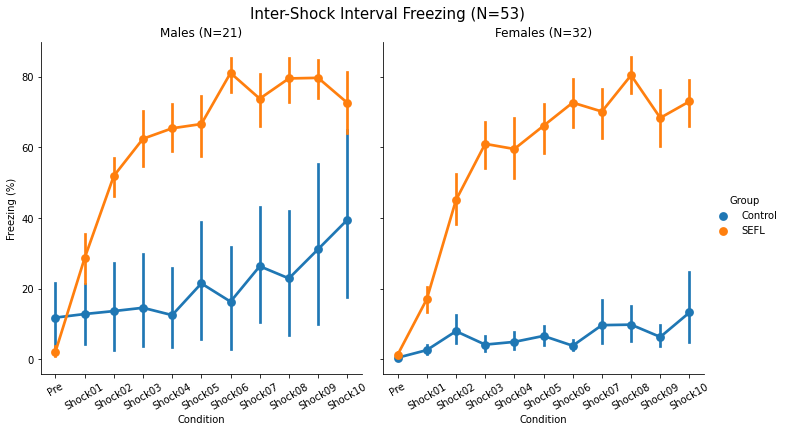

In [38]:
# Sex separated SEFLA freezing (Control vs. SEFL)

females = melted_df.groupby(['Sex'])['cohort_id'].nunique().get('Female')
males = melted_df.groupby(['Sex'])['cohort_id'].nunique().get('Male')

num_sexes = melted_df.groupby(['Sex'])['cohort_id'].nunique()
num_mice = melted_df.cohort_id.nunique()

g = sns.catplot(data= melted_df, x='Condition', y='Freezing (%)',
                  hue='Group', col='Sex', kind='point')

ax1= g.facet_axis(0,0)
ax1.set_title(label=f'Males (N={males})', fontdict={'fontsize': 12})
ax2= g.facet_axis(0,1)
ax2.set_title(label=f'Females (N={females})', fontdict={'fontsize': 12})

g.fig.suptitle(f'Inter-Shock Interval Freezing (N={num_mice})', y=1.03,fontsize=15)
g.set_xticklabels(rotation = 30)

# bbox_inches="tight"

# plt.gcf().subplots_adjust(bottom=0.2)

# alternate option without .gcf
plt.subplots_adjust(bottom=0.002)
plt.subplots_adjust(bottom=0.01)

plt.savefig(os.path.join(save_dir, 'Inter-shock_selfa_freezing_grouped_by_sex_04_22_adjusted.png'),
            transparent=True, dpi=300, bbox_inches="tight")

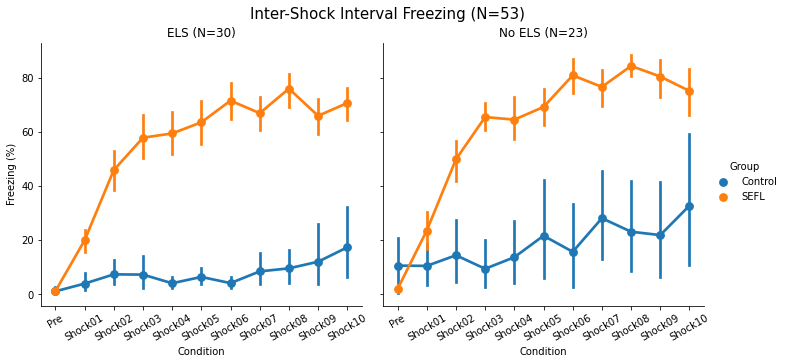

In [ ]:
# same deal as above but plotted differently

els_m = melted_df.groupby(['ELS'])['cohort_id'].nunique().get('ELS')
ctl_m = melted_df.groupby(['ELS'])['cohort_id'].nunique().get('no ELS')

# num_sexes = melted_df.groupby(['Sex'])['cohort_id'].nunique()
num_mice = melted_df.cohort_id.nunique()

g = sns.catplot(data= melted_df, x='Condition', y='Freezing (%)',
                  hue='Group', col='ELS', kind='point')
ax1= g.facet_axis(0,0)
ax1.set_title(label=f'ELS (N={els_m})', fontdict={'fontsize': 12})
ax2= g.facet_axis(0,1)
ax2.set_title(label=f'No ELS (N={ctl_m})', fontdict={'fontsize': 12})

g.fig.suptitle(f'Inter-Shock Interval Freezing (N={num_mice})', y=1.03,fontsize=15)
g.set_xticklabels(rotation = 30)

bbox_inches="tight"

plt.gcf().subplots_adjust(bottom=0.2)

# alternate option without .gcf
plt.subplots_adjust(bottom=0.2)

# plt.savefig(os.path.join(save_dir, 'Inter-shock_selfa_freezing_grouped_by_ELS_04_20.png'),
#             transparent=True, dpi=300)

the ELS and non-ELS groups needs to be compared with an ANOVA.

Working only with ELS mice from this point on. 

In [ ]:
# constructing a dataframe with ELS mice alone
els_df = melted_df[melted_df['ELS']=='ELS']
els_df.head(2)

,cohort_id,Group,Sex,genotype,ELS,Condition,Freezing (%),time
0,els1_922-1,Control,Male,wt,ELS,Pre,11.8,0
1,els1_922-2,Control,Male,wt,ELS,Pre,0.0,0


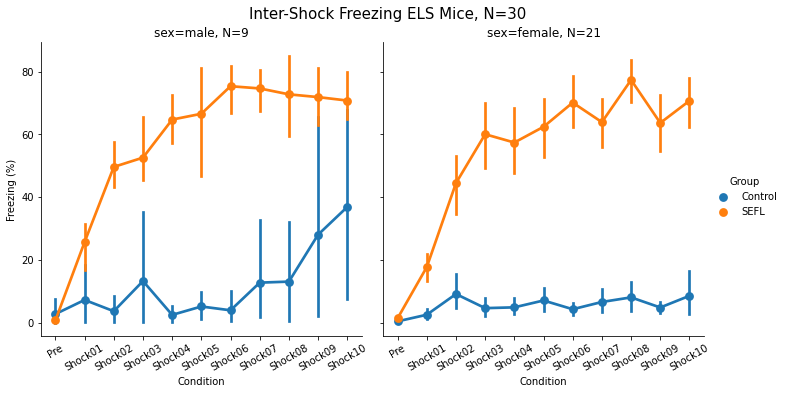

In [ ]:
# all mice broken down to SEFL-CONTROL and sex ELS included!!!

mice = els_df.cohort_id.nunique()
females = els_df.groupby(['Sex'])['cohort_id'].nunique().get('Female')
males = els_df.groupby(['Sex'])['cohort_id'].nunique().get('Male')
# plt.figure(figsize = (15,8))
num_sexes = els_df.groupby(['Sex'])['cohort_id'].nunique()
num_mice = els_df.cohort_id.nunique()

# you can plot the individual points if you replace kind="ponint" with
# estimator=None
g = sns.catplot(data= els_df, x='Condition', y='Freezing (%)',
                  hue='Group', col='Sex', kind='point')

ax1= g.facet_axis(0,0)
ax1.set_title(label=f'sex=male, (N={males})', fontdict={'fontsize': 12})
ax2= g.facet_axis(0,1)
ax2.set_title(label=f'sex=female, (N={females})', fontdict={'fontsize': 12})

g.fig.suptitle(f'Inter-Shock Freezing ELS Mice, N={mice}', y=1.03,fontsize=15)
g.set_xticklabels(rotation = 30)
# plt.savefig(os.path.join(save_dir, 'IS_freezing_ELS_grouped_by_sex_04_20.png'),
#             transparent=True, dpi=300)

STOP here. It is not tested from here 👇 yet 

calculatig learning rate based on slope of lines connecting different mean `is` freezing

In [ ]:
unmelted_df = els_df.set_index(
    ['cohort_id', 'Group', 'Sex', 'Condition']) \
              ['Freezing (%)'].unstack().reset_index(drop=True)

In [ ]:
unmelted_df.head(2)

condition,pre,shock01,shock02,shock03,shock04,shock05,shock06,shock07,shock08,shock09,shock10
0,0.00,27.92,61.92,70.91,67.63,85.47,82.77,82.47,86.08,85.04,84.12
1,0.82,12.67,44.31,45.80,59.16,68.35,75.46,78.19,69.45,71.58,68.11


In [ ]:
unmelted2_df = melted_df.set_index(
    ['cohort_id', 'Group', 'Sex', 'Condition']) \
              ['Freezing (%)'].unstack()

In [ ]:
unmelted2_df.head(2)

,,condition,pre,shock01,shock02,shock03,shock04,shock05,shock06,shock07,shock08,shock09,shock10
cohort_id,group,sex,,,,,,,,,,,
els1_300-1,sefl,male,0.00,27.92,61.92,70.91,67.63,85.47,82.77,82.47,86.08,85.04,84.12
els1_300-2,sefl,male,0.82,12.67,44.31,45.80,59.16,68.35,75.46,78.19,69.45,71.58,68.11


In [ ]:
# using shock06 as a second time point
unmelted2_df['x'] = unmelted2_df.apply(lambda row: [0.0,100.0], axis=1)
unmelted2_df['y'] = unmelted2_df.apply(lambda row: [row.Pre, row.Shock06], axis=1)

In [ ]:
# calculating slopes
unmelted2_df['slope_pre_shock06'] = unmelted2_df.apply(lambda row: linregress(row.x, row.y)[0], axis=1)

In [ ]:
unmelted2_df.index.levels

FrozenList([['els1_300-1', 'els1_300-2', 'els1_300-3', 'els1_828-1', 'els1_828-2', 'els1_828-3', 'els1_868-1', 'els1_868-2', 'els1_868-3', 'els1_902-1', 'els1_902-2', 'els1_902-3', 'els1_921-2', 'els1_921-3', 'els1_921-4', 'els1_922-1', 'els1_922-2', 'els1_922-3', 'els1_922-4', 'els1_922-5', 'els1_927-1', 'els1_927-2', 'els1_927-3', 'els1_930-1', 'els1_930-2', 'els1_930-3', 'els1_930-4', 'els1_936-1', 'els1_936-2', 'els1_939-1', 'els1_939-2', 'els1_941-1', 'els1_941-2', 'els1_941-3', 'els1_942-1', 'els1_942-2', 'els1_942-3', 'els1_942-4', 'els1_973-1', 'els1_973-2', 'els1_973-3', 'els1_973-4', 'ptsd3_1', 'ptsd3_11', 'ptsd3_12', 'ptsd3_2', 'ptsd3_3', 'ptsd5_11', 'ptsd5_12', 'ptsd5_13', 'ptsd5_61', 'ptsd5_62', 'ptsd5_64'], ['Control', 'SEFL'], ['Female', 'Male']])

In [ ]:
unm = unmelted2_df.reset_index(level=0).reset_index()
# unm2 = unm.reset_index()
unm.head(2)
unm.columns

Index(['Group', 'Sex', 'cohort_id', 'Pre', 'Shock01', 'Shock02', 'Shock03',
       'Shock04', 'Shock05', 'Shock06', 'Shock07', 'Shock08', 'Shock09',
       'Shock10', 'x', 'y', 'slope_pre_shock06'],
      dtype='object', name='Condition')

In [ ]:
# save_df = unm.loc[:,['cohort_id','slope_pre_shock06']]
# save_df.to_csv(os.path.join(savedir, 'sefla_learning_slope.csv'))

In [ ]:
remelt = pd.melt(unm, id_vars=['cohort_id', 'Group', 'Sex'],
                 value_name='slope_pre_shock06',
                 value_vars="slope_pre_shock06")
remelt.head(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


,cohort_id,Group,Sex,Condition,slope_pre_shock06
0,els1_300-1,SEFL,Male,slope_pre_shock06,0.8277
1,els1_300-2,SEFL,Male,slope_pre_shock06,0.7464


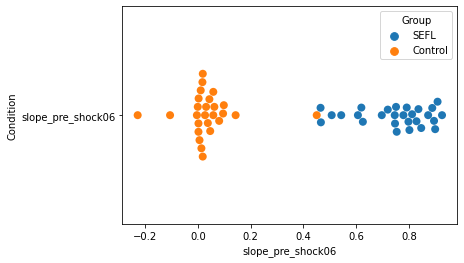

In [ ]:
# plt.figure(figsize = (15,8))
g = sns.swarmplot(x='slope_pre_shock06', y='Condition',
                  data=remelt,size=8, hue='Group')
# plt.savefig(os.path.join(savedir, 'pre_shock06_slope_allmice_swarm.png'))

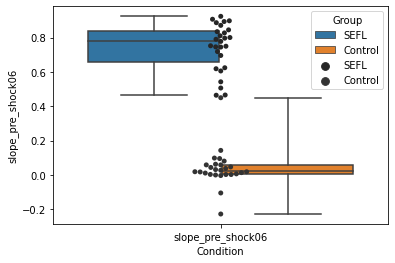

In [ ]:
# plt.figure(figsize = (15,8))
g = sns.boxplot(x='Condition', y='slope_pre_shock06',
                  data=remelt, hue='Group',whis=np.inf)
g = sns.swarmplot(x='Condition', y='slope_pre_shock06',
                  data=remelt,color='.2', hue='Group')
# plt.savefig(os.path.join(savedir, 'pre_shock06_slope_allmice_swarm_box.png'))

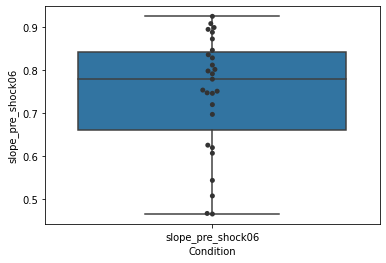

In [ ]:
sefl_mice = remelt[remelt['Group']== 'SEFL']
# plt.figure(figsize = (15,8))
g = sns.boxplot(x='Condition', y='slope_pre_shock06',
                  data=sefl_mice, whis=np.inf)
g = sns.swarmplot(x='Condition', y='slope_pre_shock06',
                  data=sefl_mice,color='.2')
# plt.savefig(os.path.join(savedir, 'pre_shock06_slope_SEFLmice_swarm_box.png'))

### TODO: calculate freezing in SEFLB (although it is pretty short)